In [46]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision.transforms import transforms
from torchvision.datasets import ImageFolder
import numpy as np
from matplotlib import pyplot as plt
import os
import csv
from PIL import Image

In [47]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

In [48]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]
)

dataset = ImageFolder("train/", transform= transform)
len(dataset)

88011

In [49]:
seed = 892
torch.manual_seed(seed)

In [50]:
batch_size = 1000
train_size = 79000
val_size = len(dataset) - train_size

val_dataset, train_dataset = data.random_split(dataset, lengths=[val_size, train_size])
full = data.DataLoader(dataset, batch_size, pin_memory=True, num_workers=1, shuffle=True, drop_last=True)

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, drop_last=False, num_workers=1)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, num_workers=1)
int(len(dataset)/batch_size)

88

In [51]:
class ImageClassifierNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        self.loss = nn.CrossEntropyLoss()

    def train_step(self, input, labels):
        input = input.to(device=device)
        labels = labels.to(device=device)

        preds = self.forward(input)
        loss = self.loss(preds, labels)

        return loss

    def val_step(self, input, labels):

        input = input.to(device=device)
        labels = labels.to(device=device)

        preds = self.forward(input)
        loss = self.loss(preds, labels)
        accuracy = self._accuracy(preds, labels)

        return {"loss":loss.detach(), "accuracy":accuracy}


    def val_epoch_end(self, preformance_measurement_data):

        accuracy = [x["accuracy"].cpu().numpy() for x in preformance_measurement_data]
        avg_accuracy = np.mean(accuracy)

        loss = [x["loss"].cpu().numpy() for x in preformance_measurement_data]
        avg_loss = np.mean(loss)

        return avg_loss, avg_accuracy


    def _accuracy(self, preds, labels):
        batch_size = len(preds)

        pred_indices = torch.argmax(preds, dim=1)
        return torch.tensor(torch.sum(pred_indices == labels).item() / batch_size)





In [52]:
class ResNetBlock(nn.Module):
    """ RestNet block with BN and full pre-activation """
    def __init__(self, in_channels, out_channels_conv1, out_channels_conv2, kernel_size=[3, 3], stride=[1,1], padding=[1,1]):
        super().__init__()

        self.network = nn.Sequential(
            nn.BatchNorm2d(in_channels),
            nn.ReLU(),
            nn.Conv2d(in_channels, out_channels_conv1, kernel_size=kernel_size[0], stride=stride[0], padding=padding[0]),
            nn.BatchNorm2d(out_channels_conv1),
            nn.ReLU(),
            nn.Conv2d(out_channels_conv1, out_channels_conv2, kernel_size=kernel_size[1], stride=stride[1], padding=padding[1])
        )


    def forward(self, input):
        return self.network(input) + input



class ResNetBlockChangeDepth(ResNetBlock):
    """ RestNet block with depth resize """
    def __init__(self, in_channels, out_channels_conv1, out_channels_conv2, res_conv_kernel_size=1, res_conv_stride=1, res_conv_padding=0, kernel_size=[3, 3], stride=[1,1], padding=[1,1]):

        super().__init__(in_channels, out_channels_conv1, out_channels_conv2, kernel_size, stride, padding)

        self.conv = nn.Conv2d(in_channels, out_channels_conv2, kernel_size=res_conv_kernel_size, stride=res_conv_stride, padding=res_conv_padding)

    def forward(self, input):
        return self.network(input) + self.conv(input)



class Wrapper(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


In [53]:
class ResNet(ImageClassifierNetwork):

    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.resnet_block1_1 = ResNetBlock(64, 64, 64)
        self.resnet_block1_2 = ResNetBlockChangeDepth(64, 128, 128)

        self.resnet_block2_1 = ResNetBlock(128, 128, 128)
        self.resnet_block2_2 = ResNetBlockChangeDepth(128, 256, 256)
        self.resnet_block2_3 = ResNetBlockChangeDepth(256, 256, 256)


        self.network = nn.Sequential(

            # Prep 3x64x64
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 32x32x32

            nn.Conv2d(32, 64, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 64x16x16

            Wrapper(self.resnet_block1_1),
            Wrapper(self.resnet_block1_2),
            nn.MaxPool2d(2, 2), # 128x8x8

            Wrapper(self.resnet_block2_1),
            Wrapper(self.resnet_block2_2),
            Wrapper(self.resnet_block2_3),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.AvgPool2d(2, 2), # 256x4x4

            nn.Flatten(),
            # Fully connected layer
            nn.Linear(4*1024, num_classes),

        )


    def forward(self, input):
        return self.network(input)

In [54]:
model = ResNet(3, 50)
model.to(device)

ResNet(
  (loss): CrossEntropyLoss()
  (resnet_block1_1): ResNetBlock(
    (network): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (resnet_block1_2): ResNetBlockChangeDepth(
    (network): Sequential(
      (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU()
      (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (4): ReLU()
      (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
  )

In [55]:
# RestNet +- 7epoch;; RestNet_2 +- 10epoch "||" z agumentacją + 30epch RestNet2
epoch = 20
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
lr_scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 6e-3, epochs=epoch, steps_per_epoch=int((len(dataset)/batch_size))) # int((len(train_dataset)/batch_size)

In [56]:
params_sum = 0
for params in model.parameters():
    params_sum+=params.view(-1).size(0)
params_sum

3025106

In [57]:
def eval(val_loader, model):
        history = []
        for input, label in val_loader:
            history += [model.val_step(input, label)]

        loss_val, acc_val = model.val_epoch_end(history)

        return loss_val, acc_val

In [58]:
torch.manual_seed(seed=torch.initial_seed())

transform = transforms.RandomChoice(
    [
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomVerticalFlip(0.5),
    transforms.RandomRotation(degrees=(20, 60)),
    transforms.RandomPerspective(distortion_scale=.35),

    transforms.RandomErasing(0.5),

    transforms.RandomInvert(0.5),
    ]
)

In [59]:
def train(train_dataloader, epoch):
    model.train(mode=True)

    epoch_loss_T = []
    batch_loss_T = []
    epoch_loss_V = []
    epoch_acc_V = []


    for ep in range(epoch):

        for input, label in train_dataloader:

            transformed_input = transform(input)
            loss = model.train_step(transformed_input, label)

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()
            lr_scheduler.step()

            batch_loss_T += [loss.item()]

        epoch_loss_T += [np.mean(batch_loss_T)]
        batch_loss_T = []

        loss_val, acc_val = eval(val_loader, model)
        epoch_loss_V += [loss_val]
        epoch_acc_V += [acc_val]

        print(f'Epoch {ep+1}; TLoss: {epoch_loss_T[ep]}; Vloss: {loss_val}; Acc: {acc_val}\n')


    model.eval()
    return epoch_loss_T, epoch_loss_V, epoch_acc_V

In [60]:
loss_T, loss_V, acc_V = train(full, epoch)

Epoch 1; TLoss: 3.0431072766130622; Vloss: 2.600881814956665; Acc: 0.29488182067871094

Epoch 2; TLoss: 2.610316122120077; Vloss: 2.405579090118408; Acc: 0.35707271099090576

Epoch 3; TLoss: 2.410892524502494; Vloss: 2.0801923274993896; Acc: 0.43596363067626953

Epoch 4; TLoss: 2.354255662723021; Vloss: 1.9815585613250732; Acc: 0.46995455026626587

Epoch 5; TLoss: 2.0844499197873203; Vloss: 1.8308303356170654; Acc: 0.4986545443534851

Epoch 6; TLoss: 1.8886111636053433; Vloss: 1.5771129131317139; Acc: 0.5616453886032104

Epoch 7; TLoss: 1.796482573856007; Vloss: 1.4071190357208252; Acc: 0.6079545617103577

Epoch 8; TLoss: 1.6499189043586904; Vloss: 1.3308464288711548; Acc: 0.6443272829055786

Epoch 9; TLoss: 1.6069541505791924; Vloss: 1.287715196609497; Acc: 0.6485272645950317

Epoch 10; TLoss: 1.4872621948068792; Vloss: 1.1389036178588867; Acc: 0.6788363456726074

Epoch 11; TLoss: 1.4186736345291138; Vloss: 1.0982015132904053; Acc: 0.6957363486289978

Epoch 12; TLoss: 1.31531805680556

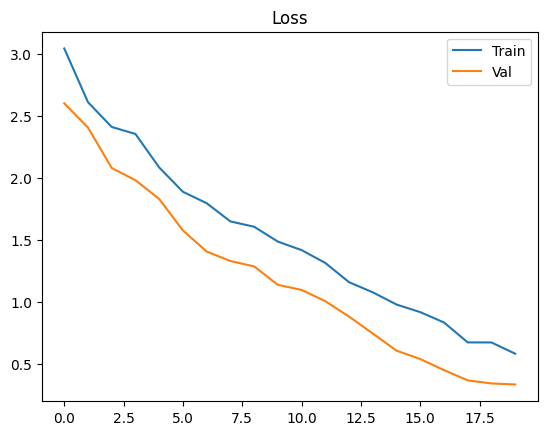

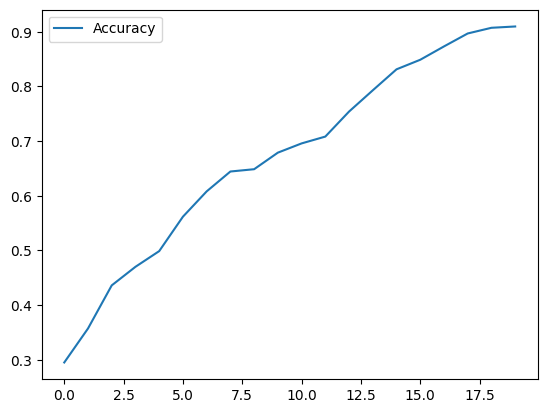

In [61]:
def plot_results(loss_T, loss_V, acc_V):

    # fig = plt.figure
    plt.plot(loss_T, label="Train")
    plt.plot(loss_V, label="Val")
    plt.title("Loss")
    plt.legend()
    plt.show()

    # fig2 = plt.figure
    plt.plot(acc_V, label="Accuracy")
    plt.legend()
    plt.show()

plot_results(loss_T, loss_V, acc_V)

In [62]:
model_name = str(epoch) + "epoch_Final2.pt"
torch.save(model.state_dict(), model_name)

### Trained models loading

In [63]:
model_name = "20epoch_Final2"
model1 = ResNet(3, 50)
model1.to(device)
model1.load_state_dict(torch.load(model_name + ".pt"))

<All keys matched successfully>

In [64]:
loss, acc = eval(train_loader, model1)
print(loss, acc)
loss, acc = eval(val_loader, model1)
print(loss, acc)
loss, acc = eval(full, model1)
print(loss, acc)

0.31787202 0.92326576
0.33626115 0.9097182
0.31883335 0.9227272


In [65]:
def preprocess_image(image_path):
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ]
    )
    image = Image.open(image_path)
    if image.mode != 'RGB':
        image = image.convert('RGB')
    image = transform(image)
    image = image.unsqueeze(0)  # batch dimension
    return image

In [66]:
def pred_save(image_dir):
    results =[]
    for filename in os.listdir(image_dir):
        if filename.endswith(".JPEG"):

            image_path = os.path.join(image_dir, filename)
            image = preprocess_image(image_path)
            image = image.to(device)
            prediction = torch.argmax(model1(image), dim=1).cpu().item()

            results.append([filename, prediction])

    # Save results to CSV
    csv_filename = "predictions_" + model_name
    with open(csv_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(results)


In [67]:
image_dir = "test_all"
pred_save(image_dir)